### Analysis & Final Processing
- This notebook focuses on analysing data to make decisions for final processing techniques such as data filtering and addressing class imbalances.
- Analysis will also be used to validate if features are useful for the machine learning model.
- Note: Run cells in sequential order to test code

In [27]:
# - [Library Imports & Calling Preprocessed Combined Data] -
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import feature_extraction_mod as fe

combined_df = pd.read_parquet('data/preprocessed_combined_data.parquet')

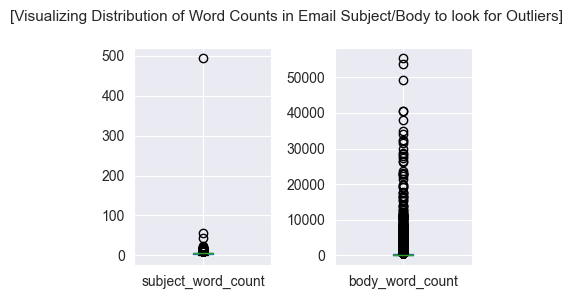

[Findings/Conclusion]:
- Extreme High Word Count found in Subject/Body.
- Using IQR and adjusting IQR multiplier to prevent significant data loss, we can effectively remove outliers in this highly skewed data.


In [28]:
# - [Visualizing Distribution of Subject & Body Word Counts] -
fig_init_wc, axs_init_wc = plt.subplots(1, 2, figsize=(4, 3))
combined_df[['subject_word_count']].boxplot(ax=axs_init_wc[0])
combined_df[['body_word_count']].boxplot(ax=axs_init_wc[1])
fig_init_wc.suptitle('[Visualizing Distribution of Word Counts in Email Subject/Body to look for Outliers]', fontsize=11)
plt.tight_layout()
plt.show()

# Findings/Conclusions
print('[Findings/Conclusion]:\n'
      '- Extreme High Word Count found in Subject/Body.\n'
      '- Using IQR and adjusting IQR multiplier to prevent significant data loss, we can effectively remove outliers in this highly skewed data.')

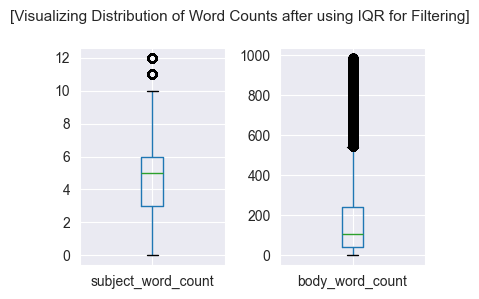

[Findings/Conclusion]:
- Threshold for Subject: 12 Words
- Threshold for Body: 988 Words
- Legit Emails Lost: 4502 out of 87918 (5.12%)
- Phishing Emails Lost: 87 out of 4622 (1.88%)
- After testing different IQR multipliers, (2x for Subject, 3x for Body) was found to set the ideal thresholds (12 Words for Subject, 988 Words for Body), without causing significant data loss.
- Hence, I will be using the thresholds obtained for filtering.


In [29]:
# - [Data Filtering - Using IQR to remove Extreme Word Count Outliers] -

# Find Q1 and Q3 of subject & body word count to calculate IQR
subject_q1, subject_q3 = combined_df['subject_word_count'].quantile(0.25), combined_df['subject_word_count'].quantile(0.75)
body_q1, body_q3 = combined_df['body_word_count'].quantile(0.25), combined_df['body_word_count'].quantile(0.75)
subject_IQR, body_IQR = subject_q3 - subject_q1, body_q3 - body_q1

# Multiplier to determine threshold for outliers
subj_IQR_multiplier, body_IQR_multiplier = 2, 3
subject_upper_bound, body_upper_bound = (subject_q3 + subj_IQR_multiplier * subject_IQR), (body_q3 + body_IQR_multiplier * body_IQR)
filtered_df = combined_df.copy()
filtered_df = filtered_df[(filtered_df['subject_word_count'] <= subject_upper_bound) & (filtered_df['body_word_count'] <= body_upper_bound)]

# Box plot new filtered word counts for subject & body
fig_wc, axs_wc = plt.subplots(1, 2, figsize=(4, 3))
filtered_df[['subject_word_count']].boxplot(ax=axs_wc[0])
filtered_df[['body_word_count']].boxplot(ax=axs_wc[1])
fig_wc.suptitle('[Visualizing Distribution of Word Counts after using IQR for Filtering]', fontsize=11)
plt.tight_layout()
plt.show()

# Ensure no significant data is lost
# Find initial count of legit & phishing emails before filtering
init_legit_emails_count = combined_df['label'].value_counts().get(0)
init_phishing_emails_count = combined_df['label'].value_counts().get(1)

# Find count of legit & phishing emails after filtering
legit_emails_count = filtered_df['label'].value_counts().get(0)
phishing_emails_count = filtered_df['label'].value_counts().get(1)

# Find data lost in percent for legit & phishing emails
legit_emails_lost = init_legit_emails_count - legit_emails_count
legit_emails_lost_percent = legit_emails_lost / init_legit_emails_count * 100
phishing_emails_lost = init_phishing_emails_count - phishing_emails_count
phishing_emails_lost_percent = phishing_emails_lost / init_phishing_emails_count * 100

# Findings/Conclusion
print('[Findings/Conclusion]:\n'
      f'- Threshold for Subject: {round(subject_upper_bound)} Words\n'
      f'- Threshold for Body: {round(body_upper_bound)} Words\n'
      f'- Legit Emails Lost: {legit_emails_lost} out of {init_legit_emails_count} ({legit_emails_lost_percent:.2f}%)\n'
      f'- Phishing Emails Lost: {phishing_emails_lost} out of {init_phishing_emails_count} ({phishing_emails_lost_percent:.2f}%)\n'
      f'- After testing different IQR multipliers, (2x for Subject, 3x for Body) was found to set the ideal thresholds (12 Words for Subject, 988 Words for Body), without causing significant data loss.\n'
      f'- Hence, I will be using the thresholds obtained for filtering.')

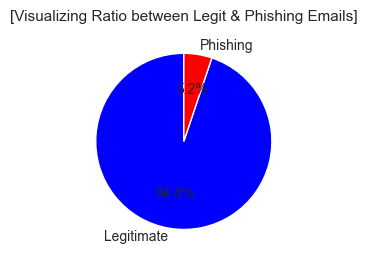

[Findings/Conclusion]:
- Legitimate Emails: 83416
- Phishing Emails: 4535
- Legitimate & Phishing emails severely imbalanced, which can bias the model towards the majority class, leading to poor performance in model.
- Hence, I will be under sampling legit emails to match phishing emails (1:1 ratio).


In [30]:
# - [Visualizing Ratio between Legit & Phishing Emails] -
sizes = [filtered_df['label'].value_counts().get(0), filtered_df['label'].value_counts().get(1)]
# Create the pie chart
plt.figure(figsize=(2.5, 2.5))
plt.pie(sizes, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
plt.title('[Visualizing Ratio between Legit & Phishing Emails]\n', fontsize=11)
plt.axis('equal')
plt.show()

# Findings/Conclusion
print('[Findings/Conclusion]:\n'
      f'- Legitimate Emails: {legit_emails_count}\n'
      f'- Phishing Emails: {phishing_emails_count}\n'
      '- Legitimate & Phishing emails severely imbalanced, which can bias the model towards the majority class, leading to poor performance in model.\n'
      '- Hence, I will be under sampling legit emails to match phishing emails (1:1 ratio).')

In [31]:
# - [Addressing Class Imbalances (After Data Filtering)] -

# Split filtered_df to legit_emails_df and phishing_emails_df
legit_emails_df = filtered_df[filtered_df['label'] == 0]
phishing_emails_df = filtered_df[filtered_df['label'] == 1]

# Under sample legit emails to match phishing emails
legit_emails_df = legit_emails_df.sample(n=len(phishing_emails_df), random_state=42)

# Recombine legit emails with phishing emails after under sampling
final_df = pd.concat([legit_emails_df, phishing_emails_df])

# Shuffle the combined df
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview final_df
final_df

,subject,body,subject_caps_percent,body_caps_percent,subject_word_count,body_word_count,unigram_count,bigram_count,trigram_count,unigram_percent,composite_score,url_label,label
0,commiss card,i am work on thi card for andi zipper and dan ...,14.29,7.02,2,35,0,0,0,0.00,0.00,0,0
1,joint ventur urgent respons need,from the desk of dr richard akuez director pro...,6.25,9.87,5,276,17,2,0,6.05,3.50,1,1
2,fia group project,attach is a word doc of some basic articl from...,0.00,1.39,3,281,6,1,0,2.11,1.33,0,0
3,immedi attent,from mr charl nwodo univers trust bank websit ...,11.11,4.18,2,609,30,3,0,4.91,6.00,0,1
4,veri urgent and confidenti,from the desk of of hassan musa the head of fi...,100.00,6.94,4,584,37,1,0,6.29,6.50,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9065,you have reciev new file,monkey org file notif hello jose you have new ...,21.74,6.40,5,70,1,0,0,1.33,0.17,1,1
9066,rv staff email access,dear staff your e mailbox password will soon e...,22.22,5.60,4,113,6,2,0,5.13,1.67,0,1
9067,confirm thi transact,confirm your transact confirm your transact fo...,9.09,6.77,3,281,13,0,0,4.58,2.17,1,1
9068,dynegi power corp master,we have a realli old agreement with the refere...,19.05,4.23,4,60,0,0,0,0.00,0.00,0,0


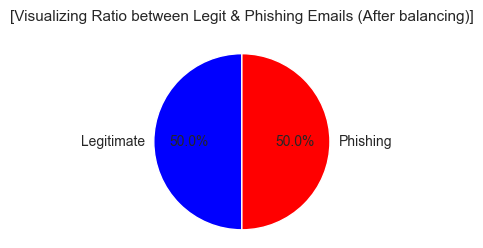

In [32]:
# - [Visualizing Ratio between Legit & Phishing Emails (After balancing)] -
sizes = [final_df['label'].value_counts().get(0), filtered_df['label'].value_counts().get(1)]
# Create the pie chart
plt.figure(figsize=(2.5, 2.5))
plt.pie(sizes, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
plt.title('[Visualizing Ratio between Legit & Phishing Emails (After balancing)]\n', fontsize=11)
plt.axis('equal')
plt.show()

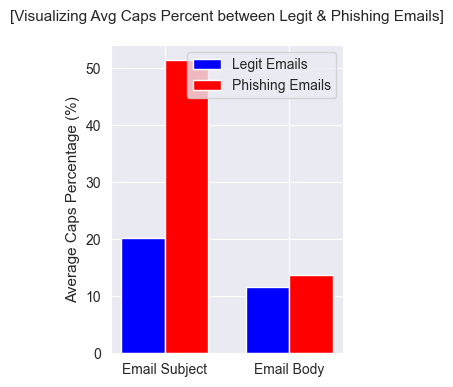

[Findings/Conclusion]:
- Legit Email Subject (Avg Caps Percent): 20.26%
- Phishing Email Subject (Avg Caps Percent): 51.41%
- Legit Email Body (Avg Caps Percent): 11.67%
- Phishing Email Body (Avg Caps Percent): 13.76%
- Caps Percent presence is overall higher in phishing emails, ensuring it is a good feature for the model.


In [33]:
# - [Visualizing Avg Caps Percent between Legit & Phishing Emails] -

# Calculate average body_caps_percent and subject_caps_percent for phishing and legitimate emails
caps_avg = final_df.groupby('label').agg({
    'body_caps_percent': 'mean',
    'subject_caps_percent': 'mean'
})
legit_subject_caps_percent = caps_avg['subject_caps_percent'][0]
phishing_subject_caps_percent = caps_avg['subject_caps_percent'][1]
legit_body_caps_percent = caps_avg['body_caps_percent'][0]
phishing_body_caps_percent = caps_avg['body_caps_percent'][1]

# Subject & Body for legit emails
legit_caps_avg = [legit_subject_caps_percent, legit_body_caps_percent]

# Subject, Body for phishing emails
phishing_caps_avg = [phishing_subject_caps_percent, phishing_body_caps_percent]

# Labels and positions
labels = ['Email Subject', 'Email Body']
bar_width = 0.35

# Two positions: one for subject_caps_percent, one for body_caps_percent
index = np.arange(2)

# Create the plot
fig, ax = plt.subplots(figsize=(3, 4))

# Bars for legitimate emails
bar1 = ax.bar(index, legit_caps_avg, bar_width, label='Legit Emails', color='blue')

# Bars for phishing emails, shifted to the right for grouping
bar2 = ax.bar(index + bar_width, phishing_caps_avg, bar_width, label='Phishing Emails', color='red')

# Add labels and title
ax.set_ylabel('Average Caps Percentage (%)', fontsize=11)
ax.set_title('[Visualizing Avg Caps Percent between Legit & Phishing Emails]\n', fontsize=11)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)

# Add a legend
ax.legend()

# Display the plot
plt.show()

# Display Statistics & Conclusion
print(f'[Findings/Conclusion]:\n'
  f'- Legit Email Subject (Avg Caps Percent): {legit_subject_caps_percent:.2f}%\n'
  f'- Phishing Email Subject (Avg Caps Percent): {phishing_subject_caps_percent:.2f}%\n'
  f'- Legit Email Body (Avg Caps Percent): {legit_body_caps_percent:.2f}%\n'
  f'- Phishing Email Body (Avg Caps Percent): {phishing_body_caps_percent:.2f}%\n'
  f'- Caps Percent presence is overall higher in phishing emails, ensuring it is a good feature for the model.')

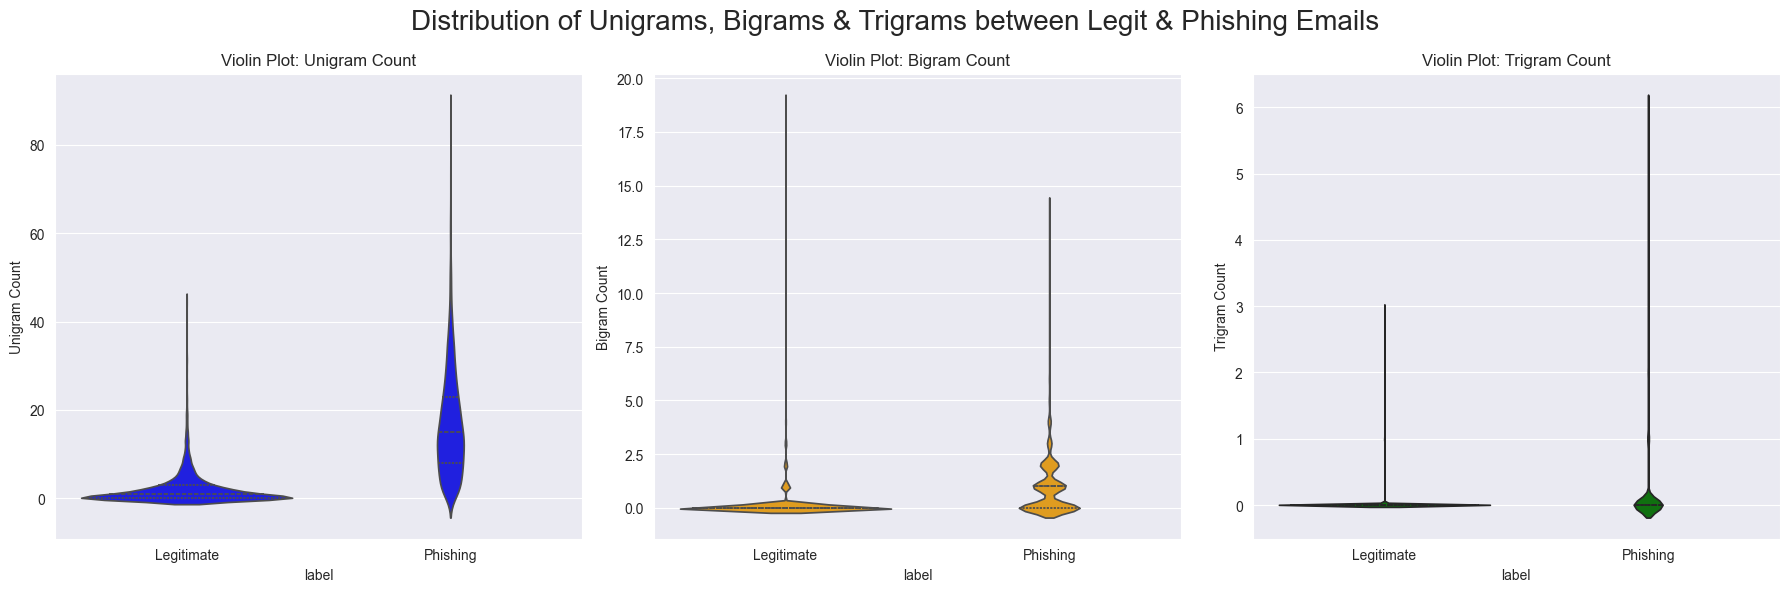

[Findings/Conclusion]:
- We can see that unigram, bigram and trigram counts are generally higher in phishing emails than legit emails, ensuring that they are good features for the model.


In [34]:
# - [Visualizing Distribution of Unigrams, Bigrams & Trigrams between Legit & Phishing Emails] -
plt.figure(figsize=(18, 6))

# Violin plot for unigram
plt.subplot(1, 3, 1)
sns.violinplot(x='label', y='unigram_count', data=final_df, inner='quartile', color='blue')
plt.title('Violin Plot: Unigram Count')
plt.ylabel('Unigram Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])

# Violin plot for bigram
plt.subplot(1, 3, 2)
sns.violinplot(x='label', y='bigram_count', data=final_df, inner='quartile', color='orange')
plt.title('Violin Plot: Bigram Count')
plt.ylabel('Bigram Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])

# Violin plot for trigram
plt.subplot(1, 3, 3)
sns.violinplot(x='label', y='trigram_count', data=final_df, inner='quartile', color='green')
plt.title('Violin Plot: Trigram Count')
plt.ylabel('Trigram Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])

plt.suptitle('Distribution of Unigrams, Bigrams & Trigrams between Legit & Phishing Emails', fontsize=20)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Findings and Conclusion
print(f'[Findings/Conclusion]:\n'
      f'- We can see that unigram, bigram and trigram counts are generally higher in phishing emails than legit emails, ensuring that they are good features for the model.')

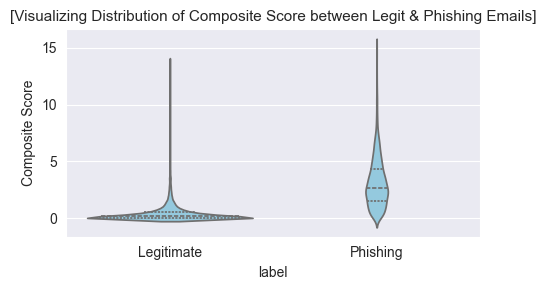

[Findings/Conclusion]:
- We can see that composite scores are generally higher in phishing emails than legit emails, ensuring that they are good features for the model.


In [35]:
# - [Visualizing Distribution of Composite Score between Legit & Phishing Emails] -

plt.figure(figsize=(5, 3))

# Create a violin plot for composite score
sns.violinplot(x='label', y='composite_score', data=final_df, inner='quartile', color='skyblue')

# Set title and labels
plt.title('[Visualizing Distribution of Composite Score between Legit & Phishing Emails]', fontsize=11)
plt.ylabel('Composite Score')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])  # Setting x-ticks to represent labels

# Show the plot
plt.tight_layout()
plt.show()

# Findings and Conclusions
print(f'[Findings/Conclusion]:\n'
      f'- We can see that composite scores are generally higher in phishing emails than legit emails, ensuring that they are good features for the model.')

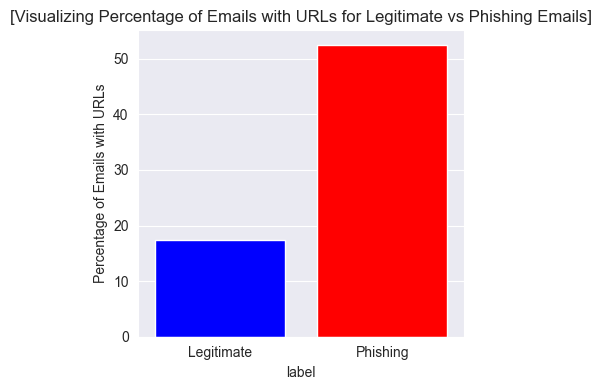

[Findings/Conclusion]:
- Using url_label, we can see that phishing emails has a higher percentage of emails containing URLs compared to legit emails, ensuring that url_label is a good feature for the model.


In [36]:
# - [Visualizing Percentage of Emails with URLs for Legitimate vs Phishing Emails] -
# Calculate the total counts for legitimate and phishing emails
total_counts = final_df['label'].value_counts()

# Calculate the counts of url_label == 1 for both legitimate and phishing emails
url_label_1_counts = final_df[final_df['url_label'] == 1]['label'].value_counts()

# Calculate the percentages
url_label_percentages = (url_label_1_counts / total_counts) * 100

# Convert to a DataFrame for better plotting
url_label_percentages_df = url_label_percentages.reset_index()
url_label_percentages_df.columns = ['label', 'percentage']

# Create a bar plot
plt.figure(figsize=(4, 4))
bars = sns.barplot(x='label', y='percentage', data=url_label_percentages_df)

# Set custom colors for the bars
colors = ['blue', 'red']  # Blue for Legitimate, Orange for Phishing
for bar, color in zip(bars.patches, colors):
    bar.set_facecolor(color)

# Set title and labels
plt.title('[Visualizing Percentage of Emails with URLs for Legitimate vs Phishing Emails]')
plt.ylabel('Percentage of Emails with URLs')

# Show the plot
plt.tight_layout()

# Display x-ticks for better visibility
plt.xticks(ticks=[0, 1], labels=['Legitimate', 'Phishing'])

plt.show()

# Findings and Conclusions
print(f'[Findings/Conclusion]:\n'
      f'- Using url_label, we can see that phishing emails has a higher percentage of emails containing URLs compared to legit emails, ensuring that url_label is a good feature for the model.')

In [38]:
# - [Finalizing Df after Analysis] -
final_df.to_csv('data/finalized_combined_df.csv', index=False)